**BERT TOKENIZATION IMPLEMENTATION**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import files
upload = files.upload()
import pandas as pd
import numpy as np

Saving Phishing.csv to Phishing.csv


In [ ]:
rachdatahug = pd.read_csv("RACH_URL_5000.csv")

In [ ]:
X=list(rachdatahug['URL'])

In [ ]:
y=list(rachdatahug['Label'])

In [ ]:
y = list(pd.get_dummies(y,drop_first=True)['good'])

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state= 0)

In [ ]:
!pip install transformers

**BERT TOKENIZATION IMPLEMENTATION**

In [ ]:
from transformers import BertTokenizer, TFBertModel
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = TFBertModel.from_pretrained("bert-base-uncased")

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
train_encodings = tokenizer(X_train, truncation=True, padding=True)
test_encodings = tokenizer(X_test, truncation=True, padding=True)

In [ ]:
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
))

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
))

In [ ]:
train_dataset

<_TensorSliceDataset element_spec=({'input_ids': TensorSpec(shape=(408,), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(408,), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(408,), dtype=tf.int32, name=None)}, TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [ ]:
from transformers import TFBertForSequenceClassification, TFTrainer, TFTrainingArguments

training_args = TFTrainingArguments(
    output_dir='./results',          # output directory
    num_train_epochs=2,              # total number of training epochs
    per_device_train_batch_size=8,  # batch size per device during training
    per_device_eval_batch_size=16,   # batch size for evaluation
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    eval_steps=10,
)

In [ ]:
!pip install --upgrade tensorflow

In [ ]:
with training_args.strategy.scope():
    model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")

trainer = TFTrainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=test_dataset             # evaluation dataset
)

trainer.train()

In [ ]:
trainer.evaluate(test_dataset)

{'eval_loss': 0.07492480855999571}

In [ ]:
trainer.predict(test_dataset)

PredictionOutput(predictions=array([[-3.1541142,  2.8970544],
       [-3.8023884,  3.4152956],
       [-3.8407516,  3.470047 ],
       ...,
       [ 3.3833935, -2.9478166],
       [-3.6145408,  3.3758733],
       [ 3.3220055, -2.9492233]], dtype=float32), label_ids=array([1, 1, 1, ..., 0, 1, 0], dtype=int32), metrics={'eval_loss': 0.07491695519649622})

In [ ]:
trainer.predict(test_dataset)[1].shape

(1047,)

In [ ]:
output=trainer.predict(test_dataset)[1]

In [ ]:
from sklearn.metrics import confusion_matrix

cm=confusion_matrix(y_test,output)
cm

array([[507,   0],
       [  0, 540]])

In [ ]:
from sklearn import metrics

In [ ]:
metrics.accuracy_score(y_test, output)

1.0

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot

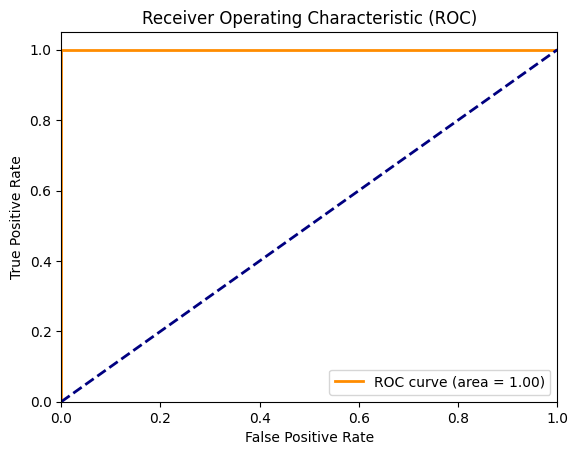

In [ ]:
fpr, tpr, _ = roc_curve(y_test,output)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()